Se importan las librerias 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from numpy import fft

def THD (RMS):
    THDi= (np.sum(RMS[2:]))/RMS[1]

    return THDi
def thdbueno(RMS, RMST):

    THDi= (RMST-RMS[1])/(RMS[1])

    return THDi



def filtro_pasabajas_ideal(signal, time, fc):
    # Calcula la transformada de Fourier de la señal
    fourier = np.fft.fft(signal)
    
    # Crea el vector de frecuencias
    freq = np.fft.fftfreq(len(signal), d=time[1] - time[0])
    
    # Aplica el filtro pasabajas ideal
    fourier_filt = fourier.copy()
    fourier_filt[np.abs(freq) > fc] = 0
    
    # Calcula la transformada inversa de Fourier
    signal_filt = np.fft.ifft(fourier_filt)
    
    return np.real(signal_filt)

def Armonicos (señal, tiempo, n):
    #T=len(tiempo)
    #T=tiempo[-1]
    T=len(tiempo)
    an=0
    bn=0
    a0=0
    for i in range (0,T,1):
        a0+=(1/T) * señal[i]
        an+=(2/T) * señal[i]*np.cos(n*2*np.pi*60*tiempo[i])
        bn+=(2/T) * señal[i]*np.sin(n*2*np.pi*60*tiempo[i])
        An=np.sqrt((an**2)+(bn**2))
        theta_n=np.arctan(bn/an)
        gamma_n=np.arctan(an/bn)
    return An, theta_n, gamma_n, a0, an, bn

##Para obtener los datos de los puntos organizados
def get_oscilloscope(ruta):
    Dataframe=pd.read_csv(ruta)
    Dataframe=Dataframe.iloc[:, 3:5] 
    Dataframe.columns=["Tiempo", "Magnitud"]
    return Dataframe 
 
def buscaarmonicos(magnitud, tiempo):
    n=50
    armonicos=np.zeros(n)
    thetas= np.zeros(n)
    gammas=np.zeros(n)
    an=np.zeros(n)
    bn=np.zeros(n)
    RMS=np.zeros(n)
    ft=0
    for j in range(1,n,1):
        armonicos[j] ,thetas[j], gammas[j], a0, an[j], bn[j]  =Armonicos(magnitud,tiempo,j)
        #ft+=armonicos[j]*np.cos(j*2*np.pi*60*tiempo-thetas[j])

        #SE HIZO CON LA OTRA FORMULA, REVISAR AN
        RMS[j]=np.sqrt(np.mean(np.square(an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo))))
        ft+=an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo)

    RMS[0]=a0
    RMS_ARMONICOS=RMS    
    ft=ft+a0
    return ft, armonicos , RMS_ARMONICOS

Carga inductiva

[-0.06778711  0.417471    0.0075992   0.01277223  0.00492203  0.00548484
  0.00296187  0.00800982  0.00184885  0.00425163  0.00626031  0.00556738
  0.00697049  0.00335024  0.00696613  0.00291593  0.00536572  0.00295112
  0.00701389  0.00444105  0.00145082  0.00303653  0.00202712  0.00847971
  0.00197008  0.00477837  0.00143909  0.00124375  0.0052153   0.00216051
  0.00298084  0.00800078  0.00160075  0.00479544  0.00289364  0.00191742
  0.00365923  0.00473911  0.00460748  0.00647707  0.00217922  0.00987259
  0.00070695  0.00405103  0.00668543  0.00174436  0.00384595  0.00190722
  0.00051931  0.00426687]


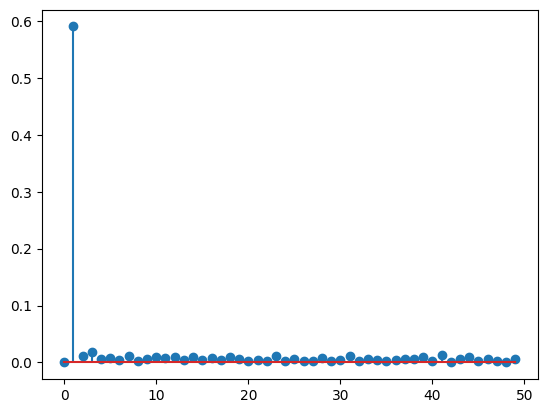

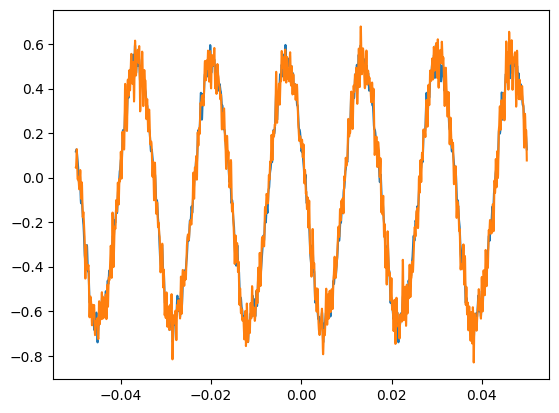

Distorsion armonica total 0.5004053161685305
Rms original0.5585885858319505
Distorsion armonica total Buena 0.3380296886138531


In [36]:
CH1=get_oscilloscope("abanico/CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("abanico/CH2.CSV")
R=10.4
CURRENT=(CH2.Magnitud-CH1.Magnitud)/10
#CURRENT=(CH1.Magnitud)
CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
ACTIVE_POWER=CURRENT*CH1.Magnitud



##Componentes armonicos
ft, armonicos, RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)

print (RMS_Armonicos)
plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CURRENT)
plt.show()

THDi=THD(RMS_Armonicos)
print("Distorsion armonica total "+ str(THDi))
print("Rms original"+ str(np.sum(RMS_Armonicos)))
max(CURRENT)
THDi=thdbueno(RMS_Armonicos,np.sum(RMS_Armonicos))
print("Distorsion armonica total Buena "+ str(THDi))

## Carga no lineal

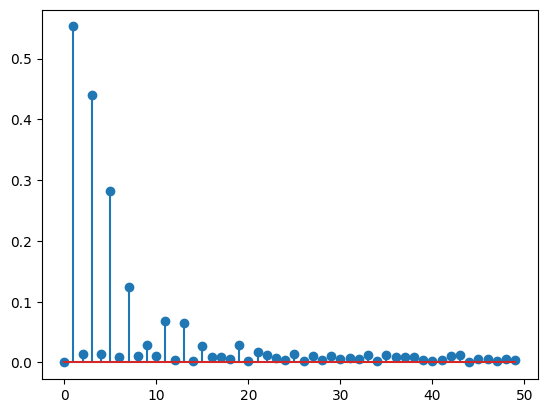

Distorsion armonica total 2.468314288625079
[0.06902761 0.39095643 0.00990233 0.31113009 0.00936718 0.19993724
 0.00688401 0.08827548 0.00795602 0.02002906 0.00726882 0.04768682
 0.00304291 0.0456851  0.00114625 0.01966373 0.00615569 0.00621133
 0.0040925  0.01999687 0.00151653 0.011739   0.00813189 0.00480148
 0.003094   0.01001253 0.00178006 0.0076178  0.00298741 0.00706293
 0.00431739 0.00481121 0.00403872 0.00905899 0.00176045 0.00899941
 0.0059036  0.00675922 0.00655299 0.00253555 0.0012305  0.00233002
 0.00728032 0.00811821 0.00105134 0.00425129 0.00378666 0.00201491
 0.00362645 0.00340103]
Distorsion armonica total Buena 2.644875167046847


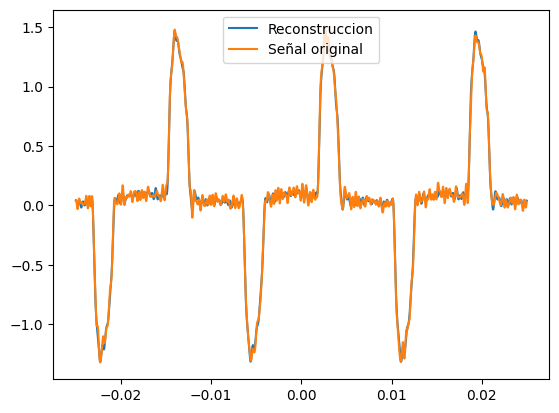

In [37]:
CH1=get_oscilloscope("PC\ALL0001\F0001CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("PC\ALL0001\F0001CH2.CSV")

R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R

CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
ACTIVE_POWER=CURRENT*CH1.Magnitud






ft, armonicos,RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)

plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft, label="Reconstruccion")
plt.plot(CH1.Tiempo,CURRENT, label="Señal original")
plt.legend()

THDi=THD(RMS_Armonicos)
print("Distorsion armonica total "+ str(THDi))

print(RMS_Armonicos)

THDi=thdbueno(RMS_Armonicos,np.sum(RMS_Armonicos))
print("Distorsion armonica total Buena "+ str(THDi))

CARGA RESISTIVA

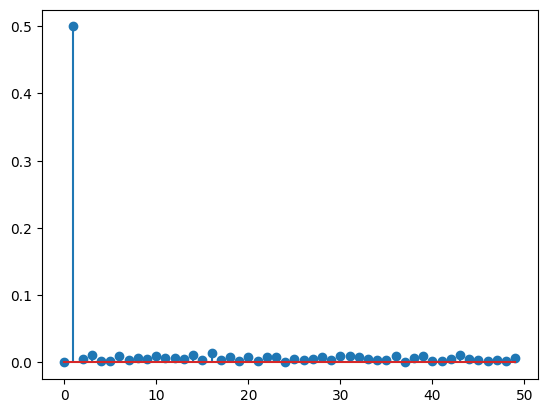

Distorsion armonica total 0.5697303970915444


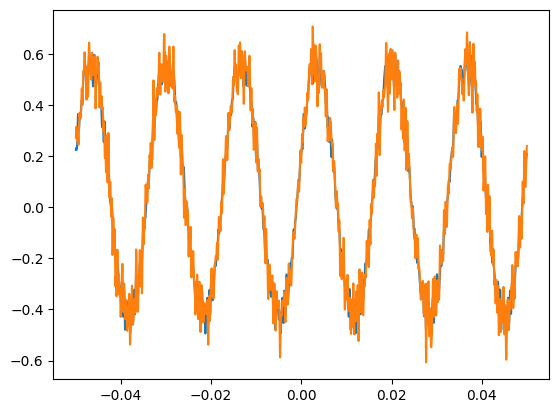

In [38]:
CH1=get_oscilloscope("cautin\F0000CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("cautin\F0000CH2.CSV")

R=10.4
CURRENT=    (CH1.Magnitud-CH2.Magnitud)/R

ACTIVE_POWER=CURRENT*CH1.Magnitud
CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
##Componentes armonicos


ft, armonicos,RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)
plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CURRENT)

THDi=THD(RMS_Armonicos)
print("Distorsion armonica total "+ str(THDi))